#**Knowledge Distillation Tutorial**

## Here we will run a number of experiments focused at improving the accuracy of a lightweight neural network, using a more powerful network as a teacher. The computational cost and the speed of the lightweight network will remain unaffected, our intervention only focuses on its weights, not on its forward pass.
### We will learn:

### * How to modify model classes to extract hidden representations and use them for further calculations

### * How to modify regular train loops in PyTorch to include additional losses on top of, for example, cross-entropy for classification

### * How to improve the performance of lightweight models by using more complex models as teachers

## **Prerequisites**

* 1 GPU, 4GB of memory

* PyTorch v2.0 or later

* CIFAR-10 dataset (downloaded by the script and saved in a directory called /data)

## **Installing the packages**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## **Loading CIFAR-10 dataset**

### The input images are RGB, so they have 3 channels and are 32x32 pixels. Basically, each image is described by 3 x 32 x 32 = 3072 numbers ranging from 0 to 255. A common practice in neural networks is to normalize the input, which is done for multiple reasons, including avoiding saturation in commonly used activation functions and increasing numerical stability. Our normalization process consists of subtracting the mean and dividing by the standard deviation along each channel. The tensors “mean=[0.485, 0.456, 0.406]” and “std=[0.229, 0.224, 0.225]” were already computed, and they represent the mean and standard deviation of each channel in the predefined subset of CIFAR-10 intended to be the training set.

In [ ]:
# use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(root='./data',
                                 train=True,
                                 download=True,
                                 transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data',
                                train=False,
                                download=True,
                                transform=transforms_cifar)

100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


## **Creating dataloaders**

In [ ]:
batch_size: int = 128
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

## **Defining model classes and utility functions**

### **Models classes: DeepRNN (teacher) + LightRNN (student)**

In [ ]:
# Deeper neural network class (teacher):
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class (student):
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### **Defining train and test functions**

### Train func takes the following arguments:

* model: A model instance to train (update its weights) via this function.

* train_loader: We defined our train_loader above, and its job is to feed the data into the model.

* epochs: How many times we loop over the dataset.

* learning_rate: The learning rate determines how large our steps towards convergence should be. Too large or too small steps can be detrimental.

* device: Determines the device to run the workload on. Can be either CPU or GPU depending on availability.

### Our test function is similar, but it will be invoked with test_loader to load images from the test set.

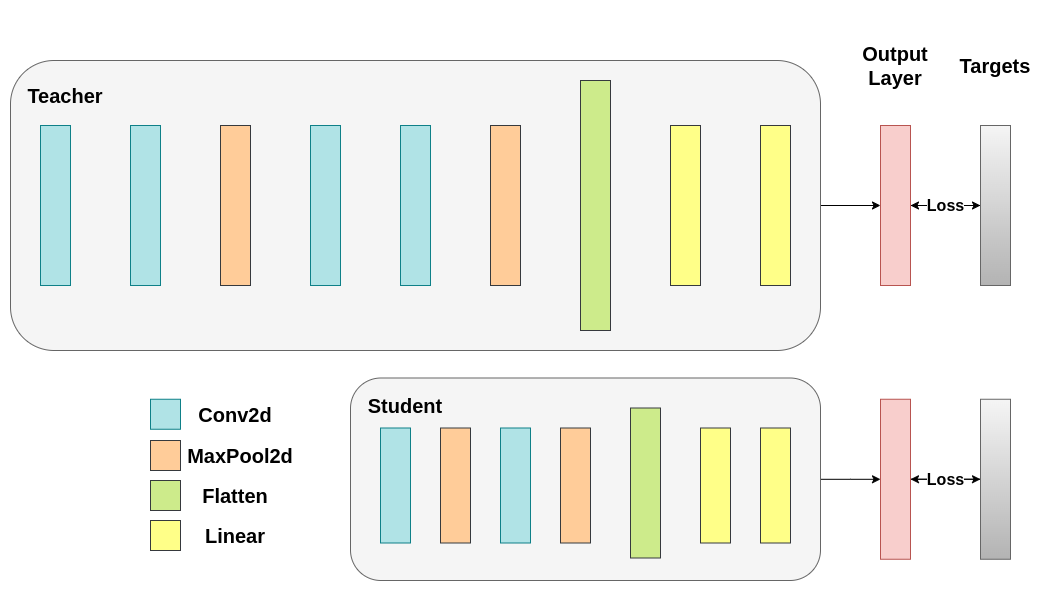

In [ ]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss() # Using Cross-Entropy as Criterion
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Using Adam as Optimizer

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

## **Cross-entropy runs**

In [ ]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

Epoch 1/10, Loss: 1.3413000173885803
Epoch 2/10, Loss: 0.8696376333761093
Epoch 3/10, Loss: 0.6783673486593739
Epoch 4/10, Loss: 0.5365854605384495
Epoch 5/10, Loss: 0.41262740232145695
Epoch 6/10, Loss: 0.2984174716731776
Epoch 7/10, Loss: 0.22078446093041573
Epoch 8/10, Loss: 0.170852712972466
Epoch 9/10, Loss: 0.14373823873641545
Epoch 10/10, Loss: 0.12228512956434504
Test Accuracy: 75.57%


In [ ]:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

### Checking the equal of 1 and 2 norm

In [ ]:
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.327361822128296
Norm of 1st layer of new_nn_light: 2.327361822128296


### The total number of parameters in each model

In [ ]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,186,986
LightNN parameters: 267,738


## **Train and test**

In [ ]:
train(nn_light, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, test_loader, device)

Epoch 1/10, Loss: 1.4691958576821915
Epoch 2/10, Loss: 1.1553549179640572
Epoch 3/10, Loss: 1.0228581484931205
Epoch 4/10, Loss: 0.922297446776534
Epoch 5/10, Loss: 0.8482878781340616
Epoch 6/10, Loss: 0.7840692003059875
Epoch 7/10, Loss: 0.7172449935427712
Epoch 8/10, Loss: 0.6581042184854102
Epoch 9/10, Loss: 0.6074533701857643
Epoch 10/10, Loss: 0.5564973550226987
Test Accuracy: 70.41%


In [ ]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 75.57%
Student accuracy: 70.41%


## **Knowledge distillation run**

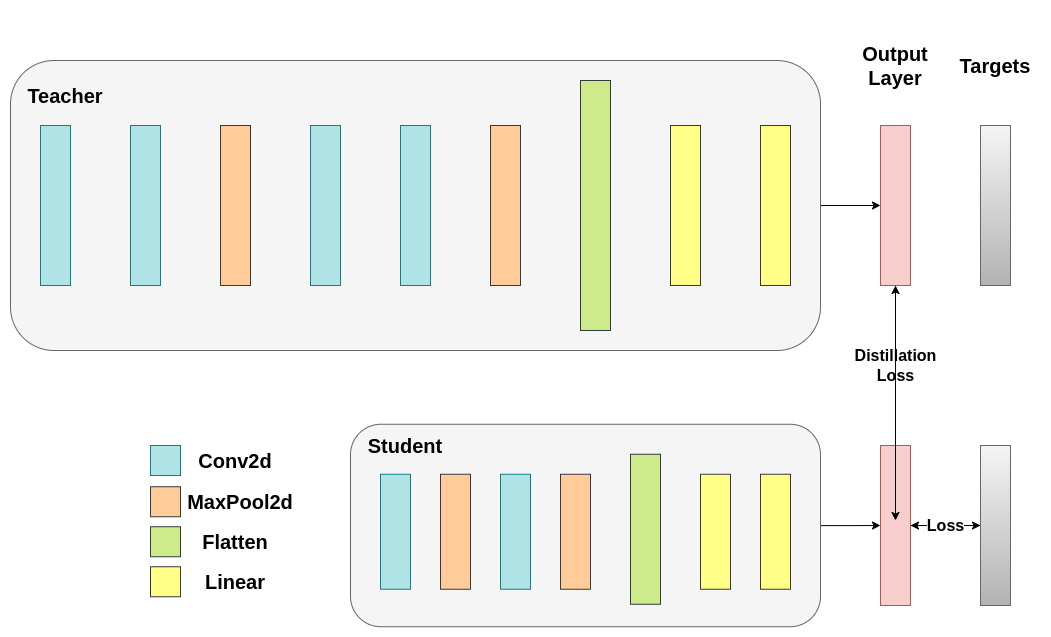

### Now let’s try to improve the test accuracy of the student network by incorporating the teacher. Knowledge distillation is a straightforward technique to achieve this, based on the fact that both networks output a probability distribution over our classes. Therefore, the two networks share the same number of output neurons. The method works by incorporating an additional loss into the traditional cross entropy loss, which is based on the softmax output of the teacher network. The assumption is that the output activations of a properly trained teacher network carry additional information that can be leveraged by a student network during training. The original work suggests that utilizing ratios of smaller probabilities in the soft targets can help achieve the underlying objective of deep neural networks, which is to create a similarity structure over the data where similar objects are mapped closer together. For example, in CIFAR-10, a truck could be mistaken for an automobile or airplane, if its wheels are present, but it is less likely to be mistaken for a dog. Therefore, it makes sense to assume that valuable information resides not only in the top prediction of a properly trained model but in the entire output distribution. However, cross entropy alone does not sufficiently exploit this information as the activations for non-predicted classes tend to be so small that propagated gradients do not meaningfully change the weights to construct this desirable vector space.

### Few extra parameters:

* T: Temperature controls the smoothness of the output distributions. Larger T leads to smoother distributions, thus smaller probabilities get a larger boost.

* soft_target_loss_weight: A weight assigned to the extra objective we’re about to include.

* ce_loss_weight: A weight assigned to cross-entropy. Tuning these weights pushes the network towards optimizing for either objective.

## **Recreating Train function**

In [ ]:
def train_knowledge_distillation(teacher,
                                 student,
                                 train_loader,
                                 epochs,
                                 learning_rate,
                                 T,
                                 soft_target_loss_weight,
                                 ce_loss_weight,
                                 device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=nn_deep,
                             student=new_nn_light,
                             train_loader=train_loader,
                             epochs=10,
                             learning_rate=0.001,
                             T=2,
                             soft_target_loss_weight=0.25,
                             ce_loss_weight=0.75,
                             device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Epoch 1/10, Loss: 2.4108632766377287
Epoch 2/10, Loss: 1.8912993065841364
Epoch 3/10, Loss: 1.6661566468455908
Epoch 4/10, Loss: 1.5058731950457445
Epoch 5/10, Loss: 1.3771918736150504
Epoch 6/10, Loss: 1.261123450210942
Epoch 7/10, Loss: 1.1664939696526588
Epoch 8/10, Loss: 1.0825263810584613
Epoch 9/10, Loss: 1.0076795279827264
Epoch 10/10, Loss: 0.9408304400151343
Test Accuracy: 70.96%
Teacher accuracy: 75.57%
Student accuracy without teacher: 70.41%
Student accuracy with CE + KD: 70.96%


### ***Results:*** test accuracy became a bit higher: 70.41% vs 70.96%.

## **Cosine loss minimization run**

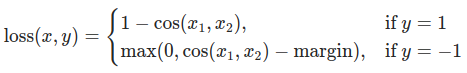

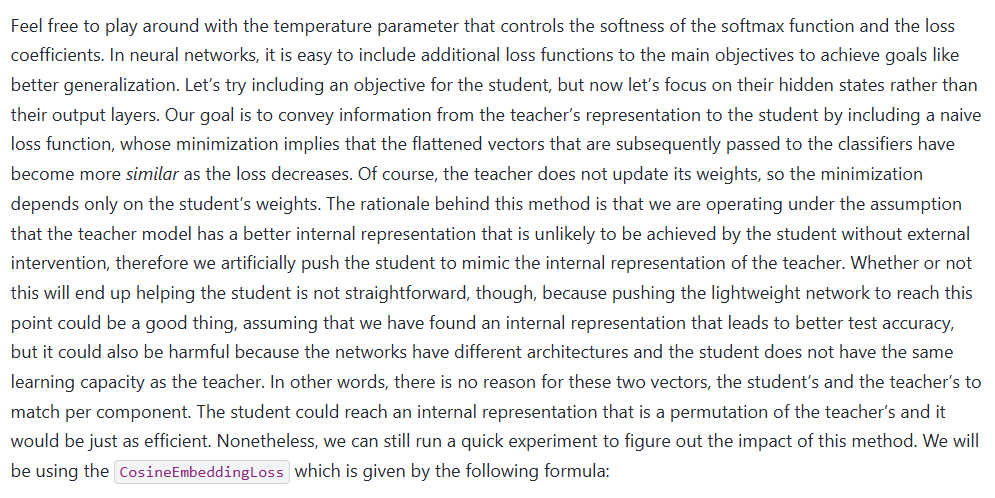

### To proceed, we will modify our model classes, or create new ones. Now, the forward function returns not only the logits of the network but also the flattened hidden representation after the convolutional layer. We include the aforementioned pooling for the modified teacher.

## **Modified DeepRNN and LightRNN classes**

In [ ]:
class ModifiedDeepNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = torch.nn.functional.avg_pool1d(flattened_conv_output, 2) # Doing avg_pool1d in forward
        return x, flattened_conv_output_after_pooling

class ModifiedLightNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        return x, flattened_conv_output # No changes except of Tuple returning

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep = ModifiedDeepNNCosine(num_classes=10).to(device)
modified_nn_deep.load_state_dict(nn_deep.state_dict())

# Checking the norms equality
print("Norm of 1st layer for deep_nn:", torch.norm(nn_deep.features[0].weight).item())
print("Norm of 1st layer for modified_deep_nn:", torch.norm(modified_nn_deep.features[0].weight).item())

# Checking the effectiveness of cosine loss minimization.
torch.manual_seed(42)
modified_nn_light = ModifiedLightNNCosine(num_classes=10).to(device)
print("Norm of 1st layer:", torch.norm(modified_nn_light.features[0].weight).item())

Norm of 1st layer for deep_nn: 7.489285945892334
Norm of 1st layer for modified_deep_nn: 7.489285945892334
Norm of 1st layer: 2.327361822128296


### Checking the test tensors shape

In [ ]:
# Create a sample input tensor
sample_input = torch.randn(128, 3, 32, 32).to(device) # Batch size: 128, Filters: 3, Image size: 32x32

# Pass the input through the student
logits, hidden_representation = modified_nn_light(sample_input)

# Print the shapes of the tensors
print("Student logits shape:", logits.shape) # batch_size x total_classes
print("Student hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

# Pass the input through the teacher
logits, hidden_representation = modified_nn_deep(sample_input)

# Print the shapes of the tensors
print("Teacher logits shape:", logits.shape) # batch_size x total_classes
print("Teacher hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

Student logits shape: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 1024])
Teacher logits shape: torch.Size([128, 10])
Teacher hidden representation shape: torch.Size([128, 1024])


## **Modifing train function for teacher - student learn**

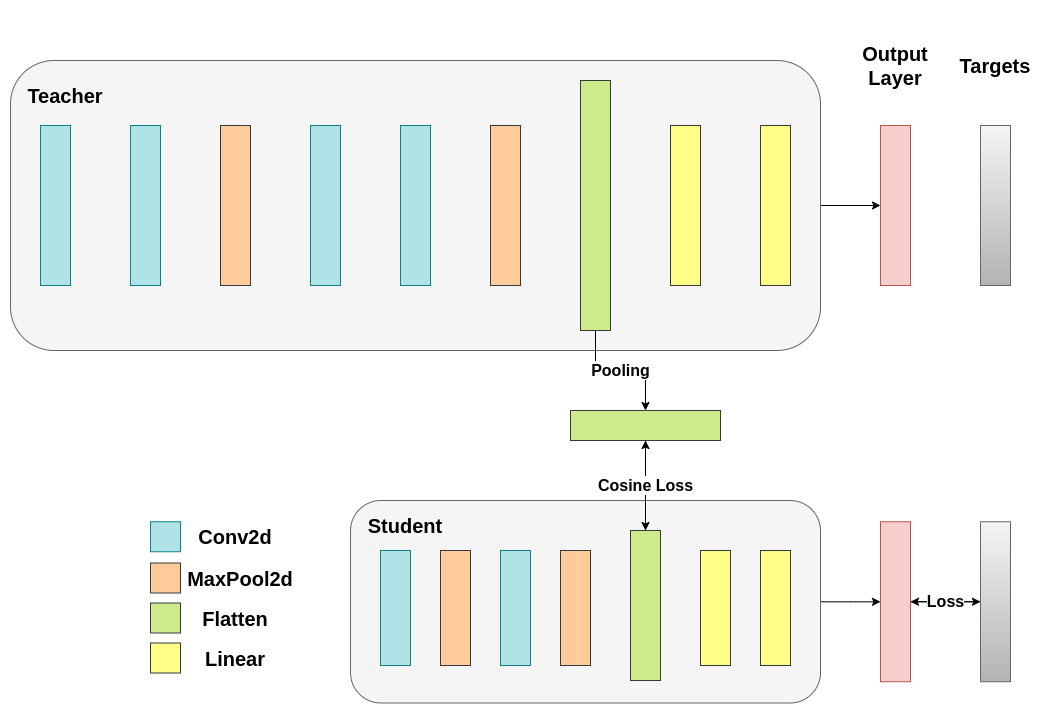

### In Cosine Loss minimization, we want to maximize the cosine similarity of the two representations by returning gradients to the student

In [ ]:
def train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, hidden_rep_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    cosine_loss = nn.CosineEmbeddingLoss() ## Adding CosineEmbeddingLoss to current CrossEntropyLoss and Adam Optimizer
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                _, teacher_hidden_representation = teacher(inputs)

            student_logits, student_hidden_representation = student(inputs)

            # Calculate the cosine loss. Target is a vector of ones. From the loss formula above we can see that is the case where loss minimization leads to cosine similarity increase.
            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))

            label_loss = ce_loss(student_logits, labels)
            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

## **Modifing test function for teacher - student learn**

In [ ]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs) # Disregard the second tensor of the tuple
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

### **Train and test new current model**

In [ ]:
train_cosine_loss(teacher=modified_nn_deep,
                  student=modified_nn_light,
                  train_loader=train_loader,
                  epochs=10,
                  learning_rate=0.001,
                  hidden_rep_loss_weight=0.25,
                  ce_loss_weight=0.75,
                  device=device)
test_accuracy_light_ce_and_cosine_loss = test_multiple_outputs(modified_nn_light,
                                                               test_loader,
                                                               device)

Epoch 1/10, Loss: 1.3092111172273642
Epoch 2/10, Loss: 1.0721677047822176
Epoch 3/10, Loss: 0.9716647293256677
Epoch 4/10, Loss: 0.8975423938782928
Epoch 5/10, Loss: 0.8426021247568642
Epoch 6/10, Loss: 0.8004419770082245
Epoch 7/10, Loss: 0.7592968321822183
Epoch 8/10, Loss: 0.7233282155393029
Epoch 9/10, Loss: 0.6871120476966623
Epoch 10/10, Loss: 0.6596296487561882
Test Accuracy: 70.56%


In [ ]:
# Pass the sample input only from the convolutional feature extractor
convolutional_fe_output_student = nn_light.features(sample_input)
convolutional_fe_output_teacher = nn_deep.features(sample_input)

# Print their shapes
print("Student's feature extractor output shape: ", convolutional_fe_output_student.shape)
print("Teacher's feature extractor output shape: ", convolutional_fe_output_teacher.shape)

Student's feature extractor output shape:  torch.Size([128, 16, 8, 8])
Teacher's feature extractor output shape:  torch.Size([128, 32, 8, 8])


### ***Results:*** test accuracy became a bit lower: 70.41% vs 70.96% vs 70.56%.

## **Intermediate regressor run**

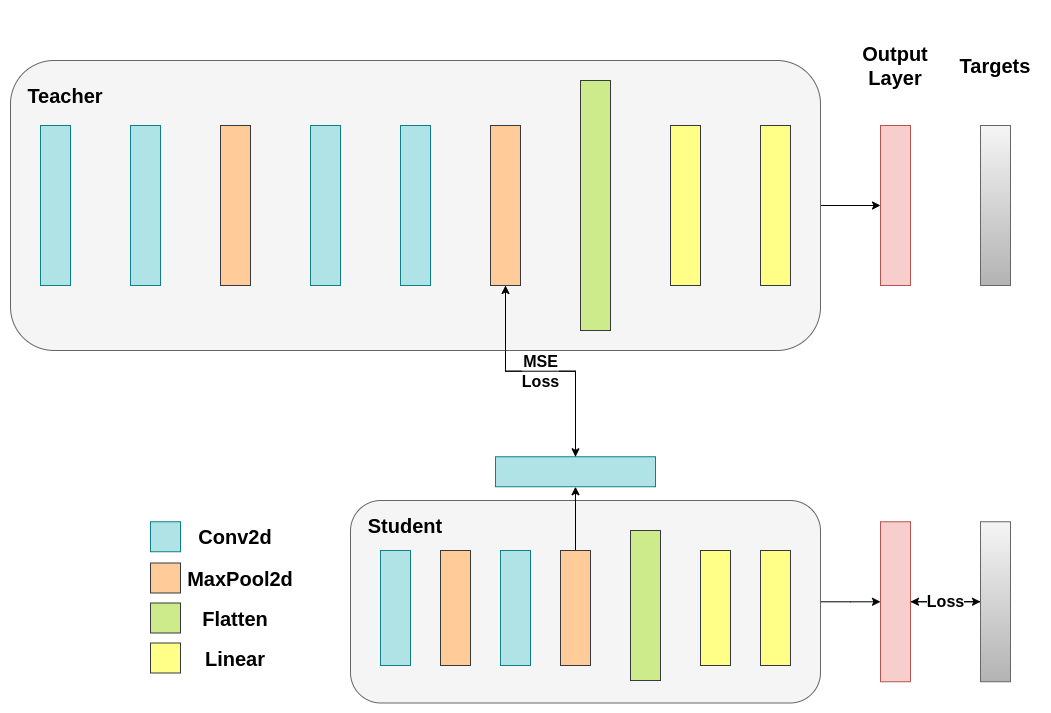

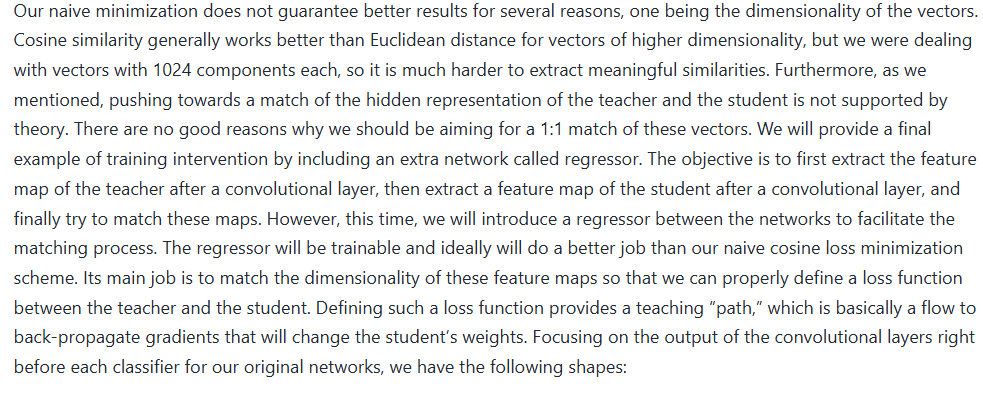

## **Modified DeepRNN and LightRNN classes**

In [ ]:
class ModifiedDeepNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map

class ModifiedLightNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Include an extra regressor (in our case linear)
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        ) # The key difference from another variant
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output

## **Updating train function**

In [ ]:
def train_mse_loss(teacher,
                   student,
                   train_loader,
                   epochs,
                   learning_rate,
                   feature_map_weight,
                   ce_loss_weight,
                   device):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss() # Adding MSELoss instead of CosineEmbeddingLoss
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)

            student_logits, regressor_feature_map = student(inputs)
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Notice how our test function remains the same here with the one we used in our previous case. We only care about the actual outputs because we measure accuracy.

# Initialize a ModifiedLightNNRegressor
torch.manual_seed(42)
modified_nn_light_reg = ModifiedLightNNRegressor(num_classes=10).to(device)

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep_reg = ModifiedDeepNNRegressor(num_classes=10).to(device)
modified_nn_deep_reg.load_state_dict(nn_deep.state_dict())

# Train and test once again
train_mse_loss(teacher=modified_nn_deep_reg,
               student=modified_nn_light_reg,
               train_loader=train_loader,
               epochs=10,
               learning_rate=0.001,
               feature_map_weight=0.25,
               ce_loss_weight=0.75,
               device=device)
test_accuracy_light_ce_and_mse_loss = test_multiple_outputs(modified_nn_light_reg,
                                                            test_loader,
                                                            device)

Epoch 1/10, Loss: 1.7316593751882958
Epoch 2/10, Loss: 1.357520358336856
Epoch 3/10, Loss: 1.212980504840841
Epoch 4/10, Loss: 1.114588705170185
Epoch 5/10, Loss: 1.036616665780392
Epoch 6/10, Loss: 0.9748833591066053
Epoch 7/10, Loss: 0.9236740299198024
Epoch 8/10, Loss: 0.8764508115056225
Epoch 9/10, Loss: 0.8325827966260788
Epoch 10/10, Loss: 0.795043146518795
Test Accuracy: 70.96%


In [ ]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")
print(f"Student accuracy with CE + CosineLoss: {test_accuracy_light_ce_and_cosine_loss:.2f}%")
print(f"Student accuracy with CE + RegressorMSE: {test_accuracy_light_ce_and_mse_loss:.2f}%")

Teacher accuracy: 75.57%
Student accuracy without teacher: 70.41%
Student accuracy with CE + KD: 70.96%
Student accuracy with CE + CosineLoss: 70.56%
Student accuracy with CE + RegressorMSE: 70.96%


### ***Results:*** test accuracy became a bit higher (as 2nd result): 70.41% vs 70.96% vs 70.56% vs 70.96%.

### ***Common results:*** Trying to use teacher-student neural models with different loss functions haven't changed a situation at all. The teacher accuracy is equal everywhere (75.57%), the maximum student model difference is 0.55% between the best model and worst model, that haven't changed a learning situation - just a small increasing. There is a way to make a test with different optimizers and Loss functions in a way to change students model accuracy.